In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler,SMOTE


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_fscore_support


#ML models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
#input data set
df = pd.read_csv('/content/drive/MyDrive/loan_data_set.csv')

In [ ]:
import re
#convert column headers to lower place
df.columns = df.columns.str.lower().str.replace(' ', '_')
#df.columns = [re.sub(r'(?<!\s)(?=[A-Z])| ', '_', col).lower() for col in df.columns]

#print columns of the dataframe
df.columns

#check structure of the data
print(df.dtypes)

#check the first five rows of the data
print (df.head())
print(df.columns)

loan_id               object
gender                object
married               object
dependents            object
education             object
self_employed         object
applicantincome        int64
coapplicantincome    float64
loanamount           float64
loan_amount_term     float64
credit_history       float64
property_area         object
loan_status           object
dtype: object
    loan_id gender married dependents     education self_employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   applicantincome  coapplicantincome  loanamount  loan_amount_term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0   

In [ ]:
#Summary Statistics
df.describe()

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


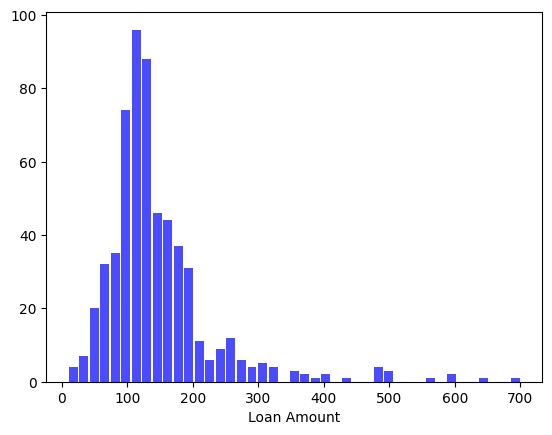

In [ ]:
#Exploratory Data Analysis
#distribution of the loan amounts
n, bins, patches = plt.hist(x=df['loanamount'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()

In [ ]:
#check the number of defaults and non-default
df['loan_status'].value_counts()


Y    422
N    192
Name: loan_status, dtype: int64

property_area  Rural  Semiurban  Urban
loan_status                           
N                 69         54     69
Y                110        179    133


Text(0.5, 0.98, '')

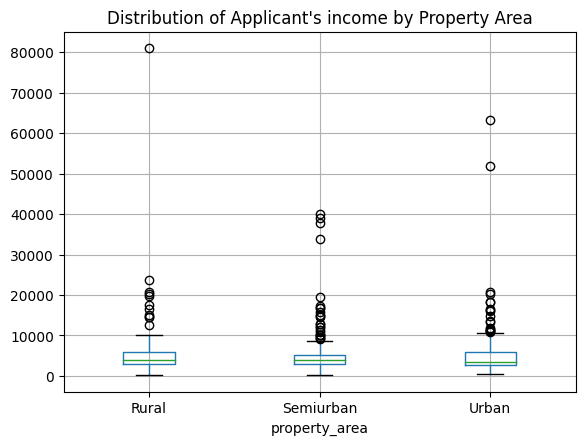

In [ ]:
#Check the distribution of Loan Status across Property area
#Semi Urban has the highest number of defaults?
print(pd.crosstab(df['loan_status'],df['property_area'],))
df.boxplot(column=['applicantincome'], by='property_area')
plt.title("Distribution of Applicant's income by Property Area")
plt.suptitle('')

In [ ]:
#check for null columns
df.isnull().sum()

loan_id               0
gender               13
married               3
dependents           15
education             0
self_employed        32
applicantincome       0
coapplicantincome     0
loanamount           22
loan_amount_term     14
credit_history       50
property_area         0
loan_status           0
dtype: int64

In [ ]:
#Feature Engineering
df['total_income'] = df['applicantincome'] + df['coapplicantincome']
print(df.head())

    loan_id gender married dependents     education self_employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   applicantincome  coapplicantincome  loanamount  loan_amount_term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   credit_history property_area loan_status  total_income  
0             1.0         Urban           Y        5849.0  
1             1.0         Rural       

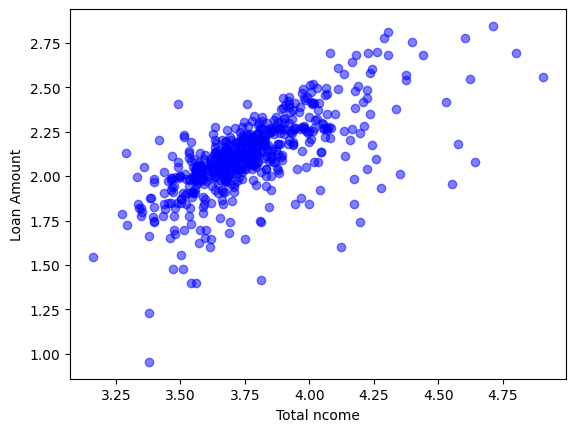

In [ ]:
# Plot a scatter plot of income against age
plt.scatter(np.log10(df['total_income']), np.log10(df['loanamount']),color='blue', alpha=0.5)
plt.xlabel('Total ncome')
plt.ylabel('Loan Amount')
plt.show()

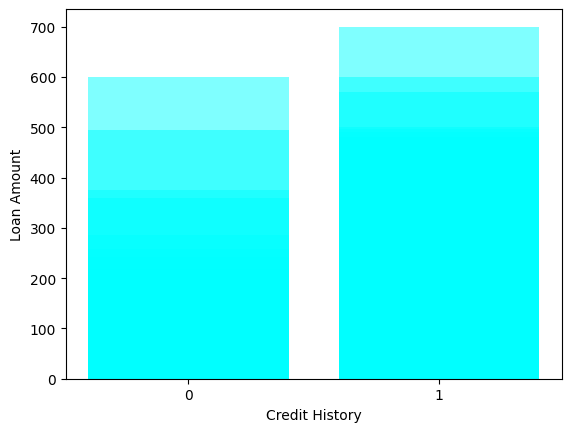

In [ ]:
#Data Visualisation
# Barplot of Credit History by Loan Amount
plt.bar(df['credit_history'], df['loanamount'], color='cyan', alpha=0.5)
plt.xlabel('Credit History')
plt.ylabel('Loan Amount')
plt.xticks([0,1])
plt.show()
#those with credit history access higher loan amounts

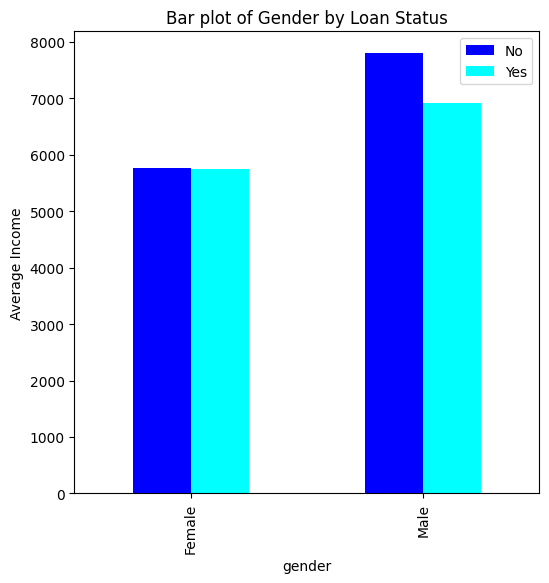

In [ ]:
# Create a cross table of Loan status, and Gender and average Income
pd.crosstab(df['gender'], df['loan_status'],  values=df['total_income'], aggfunc='mean').plot(kind='bar',figsize=(6,6),color=['blue','cyan'])
plt.legend(['No','Yes'])
plt.title('Bar plot of Gender by Loan Status')
plt.ylabel('Average Income')
plt.show()

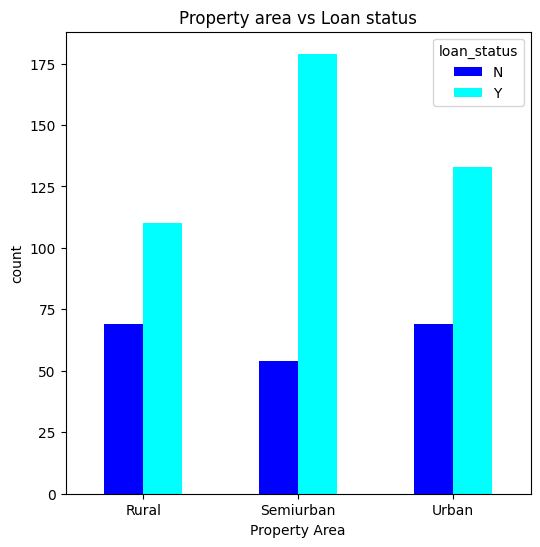

In [ ]:
pd.crosstab(df.property_area,df.loan_status).plot(kind='bar',figsize=(6,6),color=['blue','cyan'])
plt.title('Property area vs Loan status')
plt.xlabel('Property Area')
plt.ylabel('count')
plt.xticks(rotation=0)
plt.show()
#Semi urban has the highest default. This could be because they have the highest debt to income ratio.

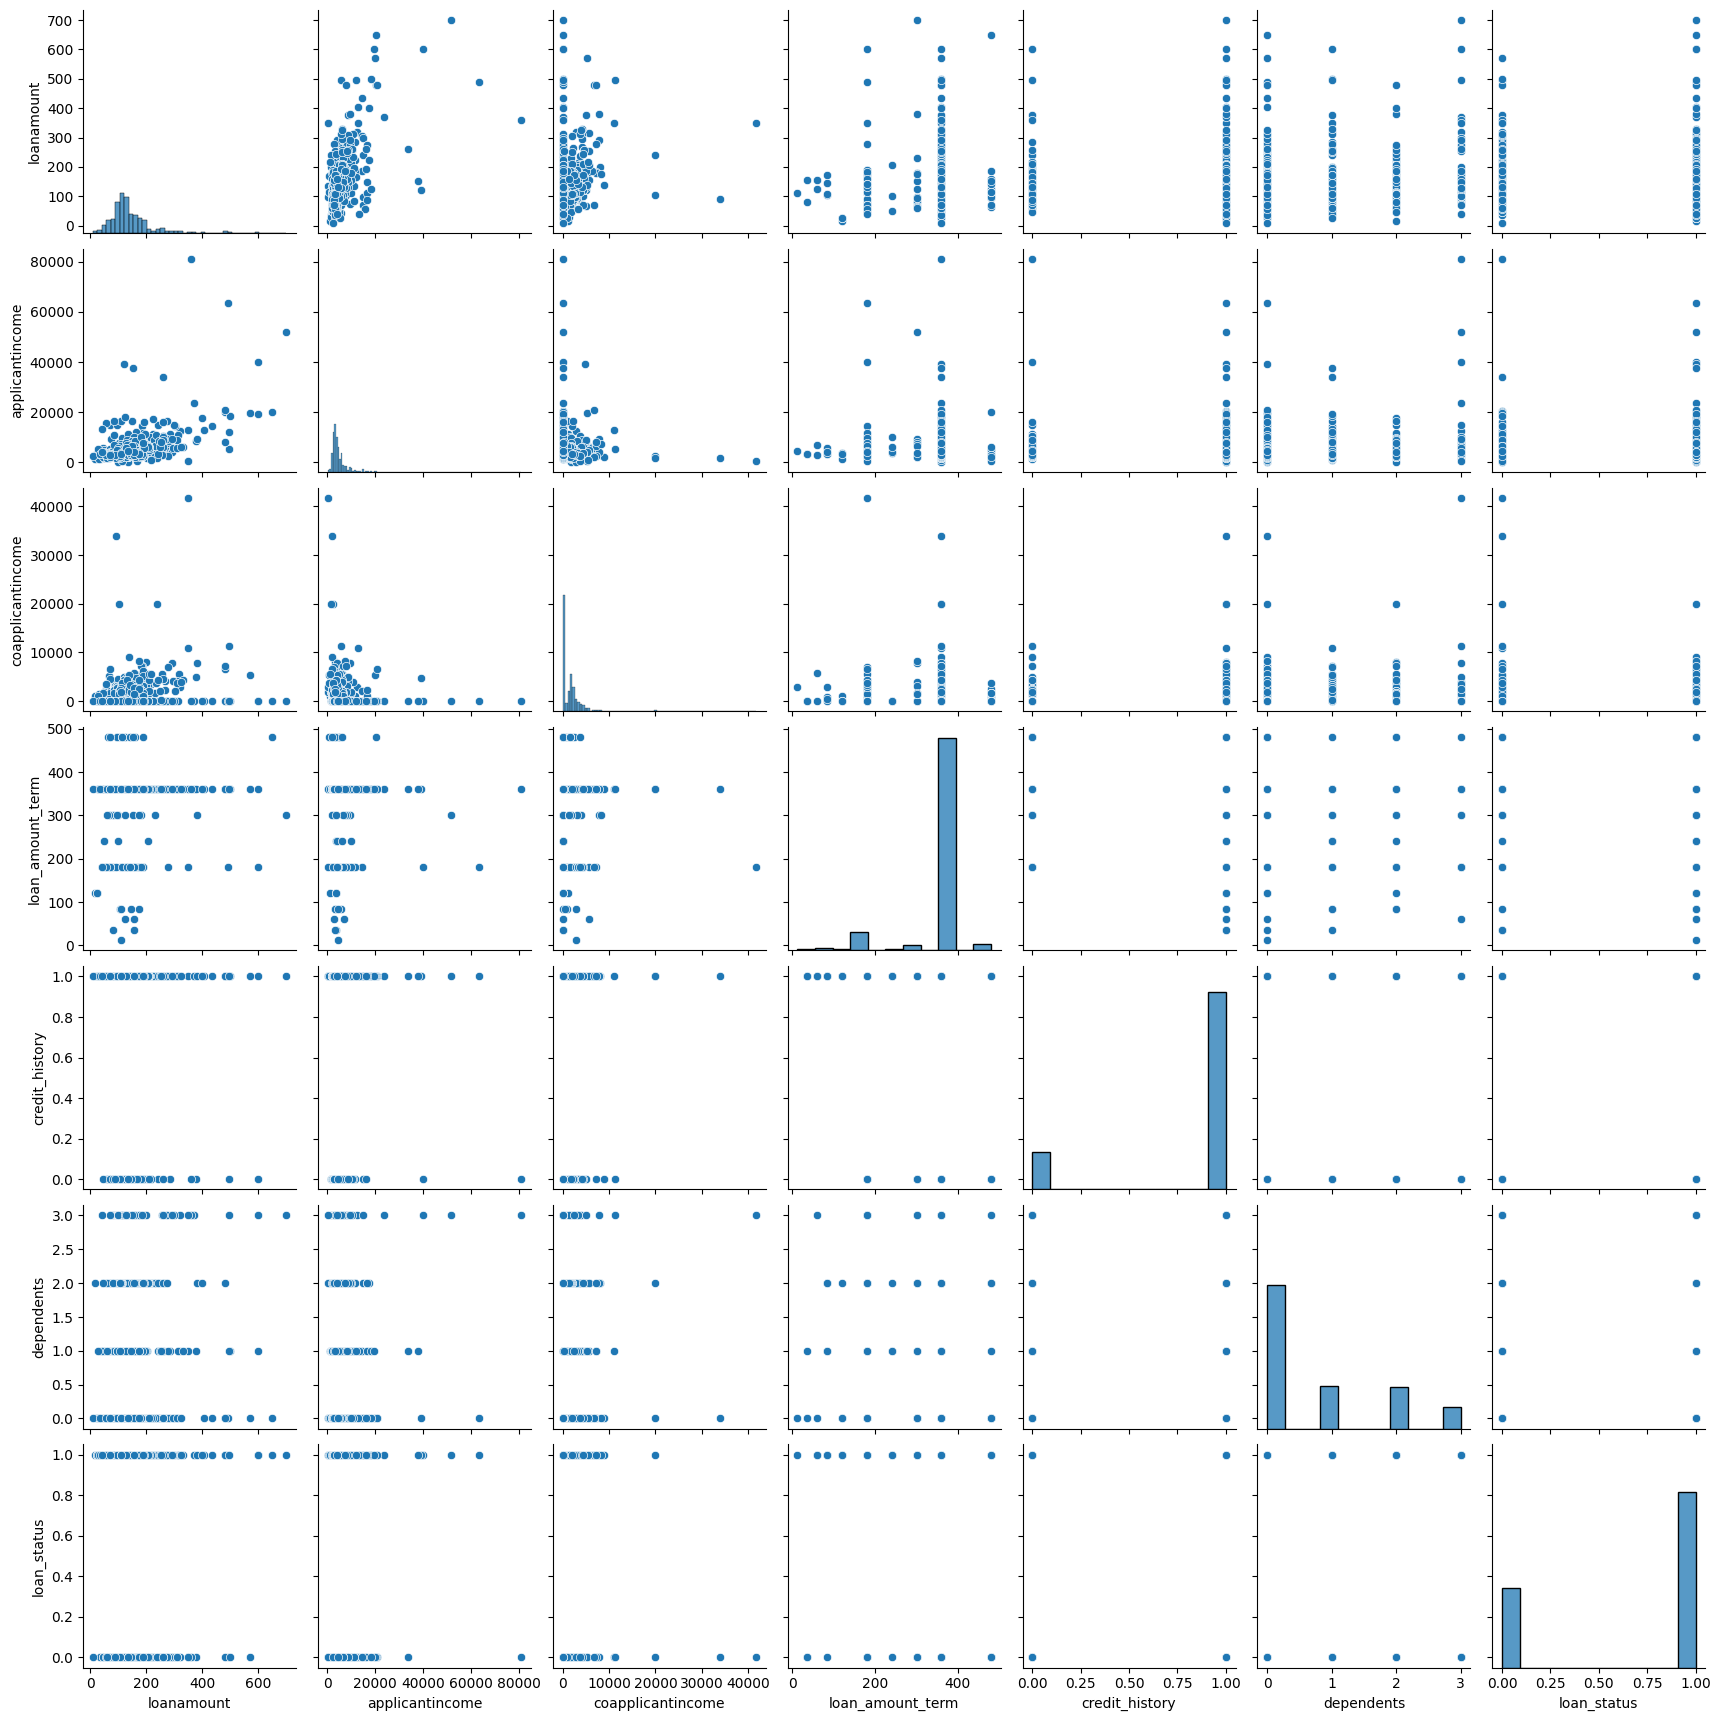

In [ ]:
#Create a pairplot
# first replace 'Y' with 1 and 'N' with 0 in loan status column in order to include it in the pair plot
#df['loan_status'] = df['loan_status'].replace({'Y': 1, 'N': 0})
#secondly convert dependents to numbers
#df['dependents']= df['dependents'].map(lambda x: int(x.replace('+', '')) if '+' in x else int(x))
dep_dict = {'Y': 1, 'N': 0, '1':1, '2':2, '3+':3}
df = df.applymap(lambda x: dep_dict.get(x) if x in dep_dict else x)

#coerce dependents column to numeric data type
df['dependents'] = pd.to_numeric(df['dependents'], errors='coerce')

#create a pairplot with the numeric variables
sns.pairplot(df[['loanamount', 'self_employed', 'applicantincome', 'coapplicantincome',
       'loan_amount_term','credit_history','dependents', 'loan_status']])



<Figure size 640x480 with 0 Axes>

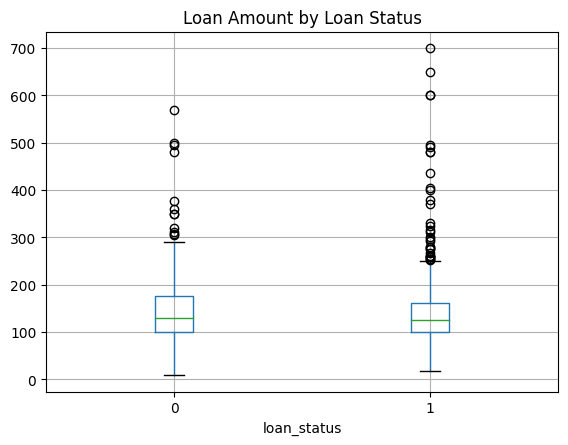

In [ ]:
# Create a box plot of Loan Amount by Loan status
plt.clf()
df.boxplot(column = ['loanamount'], by = 'loan_status')
plt.title('Loan Amount by Loan Status')
plt.suptitle('')
plt.show()

#The average applicant income seems have no significant difference.


In [ ]:
#checking the frequency of applicants whom are graduates and non-graduates
#Most oif the applicants are graduates
df['education'].value_counts()

Graduate        480
Not Graduate    134
Name: education, dtype: int64

In [ ]:
#number of male and female applicants
#there are more male than female applicants
df['gender'].value_counts()

Male      489
Female    112
Name: gender, dtype: int64

In [ ]:
#Replace missing values of the columns with the median, mode as appropriate
df['dependents'].fillna(df['dependents'].mode()[0],inplace=True)
df['self_employed'].fillna(df['self_employed'].mode()[0],inplace=True)
df['loan_amount_term'].fillna(df['loan_amount_term'].mode()[0],inplace=True)
df['credit_history'].fillna(df['credit_history'].mode()[0],inplace=True)
df['loanamount'].fillna(df['loanamount'].median(),inplace=True)

In [ ]:
df.isnull().any()

loan_id              False
gender                True
married               True
dependents           False
education            False
self_employed        False
applicantincome      False
coapplicantincome    False
loanamount           False
loan_amount_term     False
credit_history       False
property_area        False
loan_status          False
total_income         False
dtype: bool

In [ ]:
# one-hot encode the Property Area and 'Education' columns
#To enable the machine learning algorithms read the columns
df = pd.get_dummies(df, columns=['property_area', 'education'])
print(df)

      loan_id  gender married  dependents self_employed  applicantincome  \
0    LP001002    Male      No         0.0            No             5849   
1    LP001003    Male     Yes         1.0            No             4583   
2    LP001005    Male     Yes         0.0           Yes             3000   
3    LP001006    Male     Yes         0.0            No             2583   
4    LP001008    Male      No         0.0            No             6000   
..        ...     ...     ...         ...           ...              ...   
609  LP002978  Female      No         0.0            No             2900   
610  LP002979    Male     Yes         3.0            No             4106   
611  LP002983    Male     Yes         1.0            No             8072   
612  LP002984    Male     Yes         2.0            No             7583   
613  LP002990  Female      No         0.0           Yes             4583   

     coapplicantincome  loanamount  loan_amount_term  credit_history  \
0              

<ipython-input-20-46aa128516fa>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

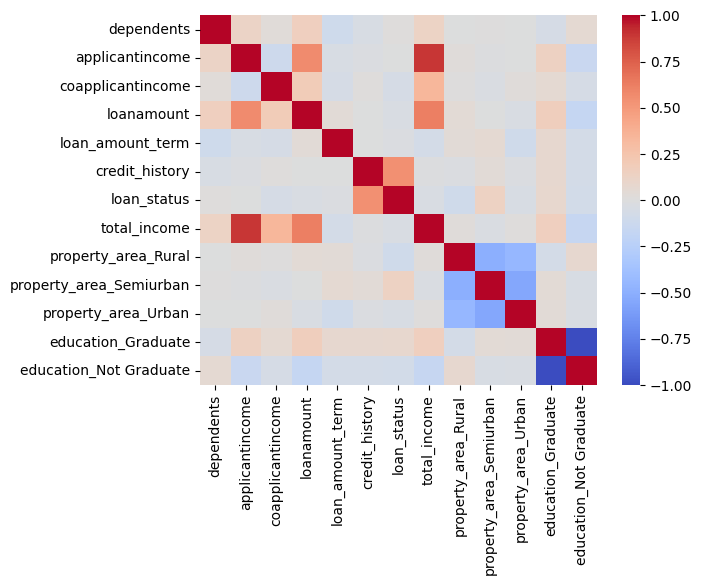

In [ ]:
#Correlation Map
#Measure the  strength of the relationships amongst the variables
#applicant income and loan amount have a fair postive correlation -0.62
#loan status and credit history also have a fair postive correlation - 0.54
#total income and education(graduate) have a fair positive corelation
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm')


1    422
0    422
Name: loan_status, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.93      0.42      0.57        65
     Default       0.76      0.98      0.86       120

    accuracy                           0.78       185
   macro avg       0.84      0.70      0.71       185
weighted avg       0.82      0.78      0.76       185



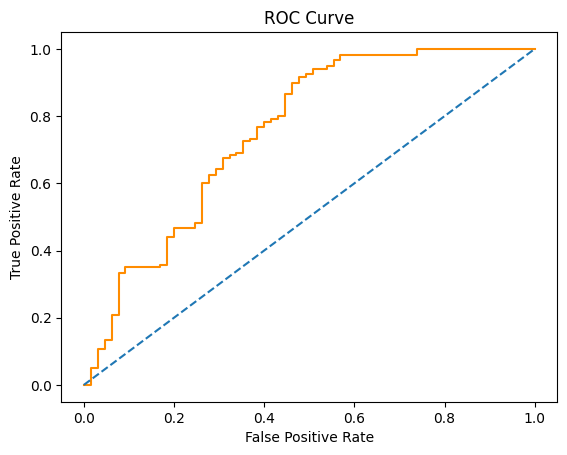

0.753974358974359
[[ 27  38]
 [  2 118]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

array([0.66350711, 0.77251185, 0.84834123, 0.78199052])

In [ ]:
#ML Models
#Logistic Regression
#predict using the model
#df_log_reg.predict()
#Split data into train and test

X = df.drop(['loan_id', 'gender','married','self_employed','loan_status', 'applicantincome','coapplicantincome'], axis=1)
y= df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3, random_state=42)


# Imbalanced Data
#the defaults are 422 far more than the non-defaults
#undersample the defaults to be equal to the defaults
#Undersampling technique
#undersampling the train dataset

# X_y_train = pd.concat([X_train.reset_index(drop = True),y_train.reset_index(drop = True)], axis = 1)

# #Create data sets for defaults and non-defaults
# nondefaults = X_y_train[X_y_train['loan_status'] == 0]
# defaults = X_y_train[X_y_train['loan_status'] == 1]

# # Undersample the defaults
# defaults_under = defaults.sample(len(nondefaults))


# # Concatenate the undersampled nondefaults with defaults
# X_y_train_under = pd.concat([defaults_under.reset_index(drop = True),nondefaults.reset_index (drop = True)], axis = 0)
# X_train_balanced = X_y_train_under.drop(['loan_status'], axis=1)
# y_train_balanced= X_y_train_under['loan_status']

#oversampling
#oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)


# # fit and apply the oversampling strategy to the non-default loans in the training data
#X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)


#scale and pipe the standard scaler and logistic model
pipe = make_pipeline(StandardScaler(), LogisticRegression())
# apply scaling on training data
pipe.fit(X_train_resampled, y_train_resampled)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

#making predictions
y_pred = pipe.predict(X_test)



#Evaluating the Logistic Regression model
# apply scaling on testing data, without leaking training data.

#check coefficients of the model
coefficients = pipe.named_steps['logisticregression'].coef_
#coefficients

# Print the classification report
# The recall for defaults is 0.84 meaning 84% of true defaults were predicted correctly.

target_names = ['Non-Default', 'Default']
print(classification_report(y_test,y_pred, target_names=target_names))

#Create an ROC Chart of the model's performance
# Create predictions and store them in a variable
preds = pipe.predict_proba(X_test)

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]

fallout, sensitivity, thresholds = roc_curve(y_test,prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Compute the AUC and store it in a variable
#the auc score is 0.94
#ROC chart shows the tradeoff between all values of our false positive rate (fallout) and true positive rate (sensitivity).
#the roc curve shows a fair lift
auc_log_reg = roc_auc_score(y_test ,prob_default)
print(auc_log_reg)

# Set the threshold for defaults to 0.5
#create a dataframe
preds_df = pd.DataFrame(prob_default, columns =['prob_default'])
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the confusion matrix
print(confusion_matrix(y_test,preds_df['loan_status']))


# Store the number of loan defaults and non defaults from the prediction data
num_defaults = preds_df['loan_status'].value_counts()[1]
num_non_defaults = preds_df['loan_status'].value_counts()[0]
# Store the default recall from the classification report
#the default recall is
default_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]
default_recall

log_ = pipe.named_steps['logisticregression']
#  Calculate the cross validation scores for 4 folds
cv_scores = cross_val_score(log_,X_train_resampled, y_train_resampled,cv = 4)
cv_scores
#the scores array([0.7218543 , 0.73509934, 0.70198675, 0.66225166]) show that the model is consistent
# Calculate the estimated impact of the  default recall rate
#Estimated loss of
#print( np.mean(df['loanamount']) * num_defaults * (1 - default_recall))

#assuming a loan of $100 is given to 100,000 people
#the expected loss would be 100,000 * 100 * (1-) = $
#however compared to the entire loan amount of $10,000,000, it is loss of  11%


Best hyperparameters: {'xgbclassifier__colsample_bytree': 0.8057568554328403, 'xgbclassifier__gamma': 0.08159418040024036, 'xgbclassifier__learning_rate': 0.011555458832196034, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__subsample': 0.8249819653888826}
{'xgbclassifier__colsample_bytree': 0.8057568554328403, 'xgbclassifier__gamma': 0.08159418040024036, 'xgbclassifier__learning_rate': 0.011555458832196034, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__subsample': 0.8249819653888826}
[17:21:17] WARNING: ../src/learner.cc:767: 
Parameters: { "xgbclassifier__colsample_bytree", "xgbclassifier__gamma", "xgbclassifier__learning_rate", "xgbclassifier__max_depth", "xgbclassifier__min_child_weight", "xgbclassifier__subsample" } are not used.

              precision    recall  f1-score   support

 Non-Default       1.00      1.00      1.00        65
     Default       1.00      1.00      1.00       120

    accuracy  

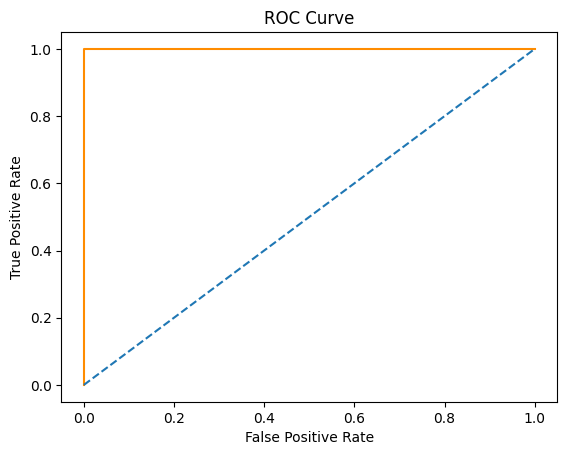

In [ ]:
# #XGBOOST
pipe_xgb = make_pipeline(StandardScaler(), XGBClassifier())
Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('xgbclassifier', XGBClassifier())])

# #Hyper parameter tuning to find the best hyper parameters
params = {
    'xgbclassifier__learning_rate': uniform(0.01, 0.3), # range of learning rates
    'xgbclassifier__max_depth': randint(1, 10), # range of max depths
    'xgbclassifier__min_child_weight': randint(1, 10), # range of min child weights
    'xgbclassifier__subsample': uniform(0.5, 0.5), # range of subsample values
    'xgbclassifier__colsample_bytree': uniform(0.5, 0.5), # range of colsample_bytree values
    'xgbclassifier__gamma': uniform(0, 1) # range of gamma values
}
# # Use RandomizedSearchCV to perform random search
rs = RandomizedSearchCV(pipe_xgb, param_distributions=params, n_iter=100, cv=5, random_state=42)

# # Fit the model on the training data
rs.fit(X_train_resampled,y_train_resampled)

# Print the best hyperparameters
print('Best hyperparameters:', rs.best_params_)
#Best hyperparameters: {'xgbclassifier__colsample_bytree': 0.8629778394351197, 'xgbclassifier__gamma': 0.8971102599525771,
#'xgbclassifier__learning_rate': 0.27612592727953517, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 1,
# 'xgbclassifier__subsample': 0.8210158230771438}


# get the best hyperparameters
best_params = rs.best_params_
print(best_params)
# create a new XGBClassifier instance with the best hyperparameters
xgb_clf = XGBClassifier(**best_params)

# create a new pipeline with StandardScaler and the updated XGBClassifier instance
pipe_xgb_new = make_pipeline(StandardScaler(), xgb_clf)

# fit the pipeline with the updated XGBClassifier to the training data
pipe_xgb_new.fit(X_train_resampled, y_train_resampled)

# try:
#     # Use RandomizedSearchCV to perform random search
#     rs = RandomizedSearchCV(pipe_xgb, param_distributions=params, n_iter=100, cv=5, random_state=42)

#     # Fit the model on the training data
#     rs.fit(X_train_resampled,y_train_resampled)
# except Exception as e:
#     print("Error occurred:", e)



# #making predictions
y_xgb_predict = pipe_xgb_new.predict(X_test)


# #classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test,y_xgb_predict, target_names=target_names))


 #Evaluate the performance of the model

# #checking probabilities of default
y_xgb_pred_proba = pipe_xgb_new.predict_proba(X_test)
y_xgb_prob_default = y_xgb_pred_proba[:,1]

#auc score  higher than the logistic regressio. it has a higer lift
auc_xgb = roc_auc_score(y_test,y_xgb_prob_default)
auc_xgb


# #Cross validating models
xgb_ = pipe_xgb_new.named_steps['xgbclassifier']
#  Calculate the cross validation scores for 4 folds
cv_scores = cross_val_score(xgb_,X_train_resampled, y_train_resampled,cv = 4)

# # Print the cross validation scores
# #the scores are 0.84768212 0.87417219 0.86754967 0.90728477 steadily improving
# #this shows that the model is consistent
print(cv_scores)


# Print the confusion matrix
print(confusion_matrix(y_test,y_xgb_predict))


# # Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
                                               cv_scores.std() * 2))

#ROC Curve
fallout, sensitivity, thresholds = roc_curve(y_test,y_xgb_prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


              precision    recall  f1-score   support

 Non-Default       0.93      0.42      0.57        65
     Default       0.76      0.98      0.86       120

    accuracy                           0.78       185
   macro avg       0.84      0.70      0.71       185
weighted avg       0.82      0.78      0.76       185

              precision    recall  f1-score   support

 Non-Default       1.00      1.00      1.00        65
     Default       1.00      1.00      1.00       120

    accuracy                           1.00       185
   macro avg       1.00      1.00      1.00       185
weighted avg       1.00      1.00      1.00       185

The f1 score for the Logisitic Regression model is 0.71
The f1 score for the XGBoost model is 1.00


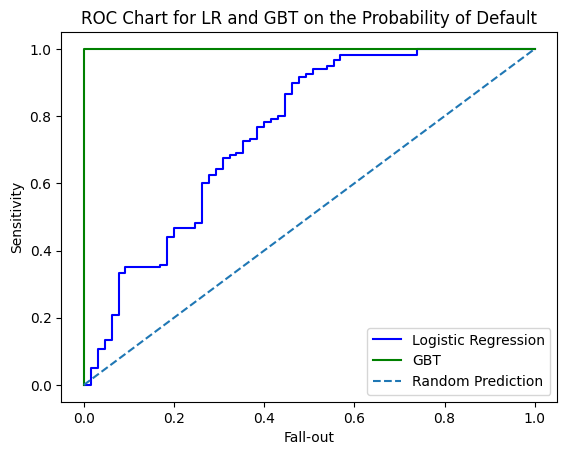

0.0


In [ ]:
#Comparing Models
xgb_preds_df = pd.DataFrame(y_xgb_predict, columns =['loan_status'])
# Store the number of loan defaults  from the prediction data
num_defaults_xgb = xgb_preds_df['loan_status'].value_counts()[1]
# Store the default recall from the classification report
#the default recall is
default_recall_xgb = precision_recall_fscore_support(y_test,xgb_preds_df['loan_status'])[1][1]
default_recall


#the scores from the classification_report() are all higher for the gradient boosted tree.
#This means the tree model is better in all of these aspects. Let's check the ROC curve.
# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

# Print the gradient boosted tree classification report
print(classification_report(y_test, xgb_preds_df['loan_status'], target_names=target_names))

# Print the default F-1 scores for the logistic regression
print('The f1 score for the Logisitic Regression model is {:.2f}'.format(precision_recall_fscore_support(y_test,preds_df['loan_status'], average = 'macro')[2]))

# Print the default F-1 scores for the gradient boosted tree
print('The f1 score for the XGBoost model is {:.2f}'.format(precision_recall_fscore_support(y_test,xgb_preds_df['loan_status'], average = 'macro')[2]))


# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test,prob_default)
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test,y_xgb_prob_default)

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt,sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()


#gradient boosted tree  has the best overall performance.
#checking the calibration of the two models to see how stable the default prediction performance is across probabilities.



# Calculate the estimated impact of the  default recall rate
#Estimated loss of
print( np.mean(df['loanamount']) * num_defaults_xgb * (1 - default_recall_xgb))

#assuming a loan of $100 is given to 100,000 people
#the expected loss would be 100,000 * 100 * (1-) = $
#however compared to the entire loan amount of $10,000,000, it is loss of
#The Gradient boost has an improvement from the logistic regression

#This shows how a slight improvement in a model can reduce losses for a business

In [ ]:
#Generate weight of columns
# Get the XGBClassifier object from the pipeline
xgb_clf = pipe_xgb_new.named_steps['xgbclassifier']

# Get the feature importances
importances = xgb_clf.feature_importances_
#print(importances)
# Get the feature names from the StandardScaler object in the pipeline
feature_names = X_train_resampled.columns

# Create a dictionary of feature importance scores mapped to feature names
feature_importances = dict(zip(feature_names, importances))

# Sort the feature importances by value (in descending order)
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

# Get the top 5 most important features
top_features = list(sorted_feature_importances.keys())[:5]
print('The top 5 most important features are:')
for i in top_features:
 print(i)


The top 5 most important features are:
credit_history
property_area_Rural
education_Not Graduate
property_area_Semiurban
property_area_Urban
